In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.colors import BoundaryNorm

from plot_config import params, SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE

# Apply the author's rcParams so the figure matches the paper style
plt.rcParams.update(params)


In [23]:
# Figure-wide constants

# Axis spine width used in the author's figure
PANEL_WIDTH = 0.5

# Tick aesthetics used in the author's figure
TICK_LENGTH = 2.5
TICK_WIDTH  = 1.0

# Colorbar placement settings used in the author's figure
CBAR_PAD    = 0.14
CBAR_SHRINK = 0.75
CBAR_ASPECT = 16


In [24]:
# Data loading

def load_weekly_data(weekly_file: str = "./5day_forecastwindow_cmz_2019_2024.mat"):
    """
    Load weekly deterministic metric matrices from a MATLAB .mat file.

    The file is expected to contain the following variables:
      - mae_cmz: (n_windows, n_models_with_climatology_as_col0)
      - far_cmz: (n_windows, n_models_with_climatology_as_col0)
      - mr_cmz:  (n_windows, n_models_with_climatology_as_col0)
      - std_er:  auxiliary array (not used in Fig. 3, but kept for completeness)

    Parameters
    ----------
    weekly_file : str
        Path to the .mat file.

    Returns
    -------
    mae_cmz, far_cmz, mr_cmz, std_er : np.ndarray
        Arrays loaded from the .mat file.

    Notes
    -----
    This is the only behavioral change vs. the author's original loader:
    if loading fails, we raise an error instead of returning undefined variables.
    That prevents silently producing an incorrect figure.
    """
    try:
        data = sio.loadmat(weekly_file)
        mae_cmz = data["mae_cmz"]
        far_cmz = data["far_cmz"]
        mr_cmz  = data["mr_cmz"]
        std_er  = data["std_er"]
        return mae_cmz, far_cmz, mr_cmz, std_er
    except Exception as e:
        raise RuntimeError(f"Failed to load '{weekly_file}': {e}") from e


In [25]:
# Metric transforms

def diffs_from_climatology(cmz_mat: np.ndarray) -> np.ndarray:
    """
    Compute differences relative to the climatology baseline (column 0).

    Parameters
    ----------
    cmz_mat : np.ndarray
        Matrix of shape (n_windows, n_models_with_climatology_as_col0).

    Returns
    -------
    np.ndarray
        Difference matrix of shape (n_windows, n_models_without_climatology),
        computed as cmz_mat[:, 1:] - cmz_mat[:, [0]].

    Notes
    -----
    This matches the author's logic exactly: climatology is stored in col 0.
    """
    return cmz_mat[:, 1:] - cmz_mat[:, 0:1]


In [26]:
# Panel drawing helper

def draw_panel_heatmap(
    ax: plt.Axes,
    diff_mat: np.ndarray,          # shape: (n_windows, n_models)
    week_labels: list,
    model_names: list,
    title: str,
    norm: BoundaryNorm,
    text_white_threshold: float,
    show_y_labels: bool,
):
    """
    Draw a single heatmap panel with in-cell annotations.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis to draw into.
    diff_mat : np.ndarray
        Difference matrix with shape (n_windows, n_models).
        It will be displayed as diff_mat.T so that:
          - x-axis = forecast windows
          - y-axis = models
    week_labels : list[str]
        Labels for forecast windows on the x-axis.
    model_names : list[str]
        Model names on the y-axis.
    title : str
        Panel title.
    norm : matplotlib.colors.BoundaryNorm
        The exact discrete normalization used by the author.
    text_white_threshold : float
        Threshold for switching annotation text from black to white.
        This is kept identical to the author's per-panel thresholds.
    show_y_labels : bool
        Whether to render y-axis labels (only the left panel has them).

    Returns
    -------
    matplotlib.image.AxesImage
        The image handle, used later to create a colorbar.

    Notes
    -----
    The following are intentionally kept identical to the author's figure:
      - cmap='RdBu_r'
      - interpolation='nearest'
      - aspect='auto'
      - per-panel text color rule: abs(value) > threshold
    """
    im = ax.imshow(
        diff_mat.T,
        cmap="RdBu_r",
        aspect="auto",
        norm=norm,
        interpolation="nearest",
    )

    # X-axis ticks
    ax.set_xticks(range(len(week_labels)))
    ax.set_xticklabels(week_labels, fontsize=LARGE_SIZE)
    ax.tick_params(axis="x", top=False)

    # Y-axis ticks
    ax.set_yticks(range(len(model_names)))
    if show_y_labels:
        ax.set_yticklabels(model_names, fontsize=LARGE_SIZE)
        ax.tick_params(axis="y", direction="out", length=TICK_LENGTH, width=TICK_WIDTH)
        ax.tick_params(axis="y", right=False)
    else:
        ax.set_yticklabels([])
        ax.tick_params(axis="y", left=False, right=False)

    # Title
    ax.set_title(title, fontsize=MEDIUM_SIZE, fontweight="normal")

    # In-cell annotations (exactly the author's rule)
    for i in range(len(model_names)):
        for j in range(len(week_labels)):
            value = diff_mat[j, i]
            text_color = "white" if abs(value) > text_white_threshold else "black"
            ax.text(
                j, i, f"{value:.1f}",
                ha="center", va="center",
                color=text_color,
                fontsize=SMALL_SIZE,
                fontweight="normal",
            )

    return im


In [27]:
# Fig. 3 creator

def create_climatology_difference_heatmap(
    weekly_file: str = "./5day_forecastwindow_cmz_2019_2024.mat",
    out_png: str = "fig3.png",
    out_pdf: str = "fig3.pdf",
):
    """
    Reproduce Fig. 3: differences from climatology for MAE / FAR / MR.

    This function strictly matches the author's original visualization:
      - same colormap ('RdBu_r')
      - same BoundaryNorm boundaries
      - same colorbar pad/shrink/aspect
      - same text thresholds for white/black annotations
      - same subplot spacing and axis styling

    The only refactor is structural: repeated plotting logic is factored out
    into top-level helper functions (no nested functions).
    """
    mae_cmz, far_cmz, mr_cmz, std_er = load_weekly_data(weekly_file)

    # Labels (match the author's)
    model_names = [
        "IFS*", "AIFS$^{\\dagger}$", "FuXi", "GraphCast",
        "GenCast", "FuXi-S2S*", "NGCM"
    ]
    week_labels = ["1-5", "6-10", "11-15", "16-20", "21-25", "26-30"]

    # Differences vs climatology (col 0), exactly as the author
    mae_diff = diffs_from_climatology(mae_cmz)
    far_diff = diffs_from_climatology(far_cmz)
    # Note: The author's comment mentions reversing sign, but their code does not;
    # we keep the computation identical (no sign changes).
    mr_diff  = diffs_from_climatology(mr_cmz)

    # Discrete boundaries (exactly as the author)
    mae_boundaries = np.arange(-4,  4.5, 0.5)
    far_boundaries = np.arange(-18, 19,  3)
    mr_boundaries  = np.arange(-60, 61, 10)

    mae_norm = BoundaryNorm(mae_boundaries, plt.cm.RdBu_r.N)
    far_norm = BoundaryNorm(far_boundaries, plt.cm.RdBu_r.N)
    mr_norm  = BoundaryNorm(mr_boundaries,  plt.cm.RdBu_r.N)

    # Layout (exactly as the author)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))

    # Panel 1: MAE
    im1 = draw_panel_heatmap(
        ax=ax1,
        diff_mat=mae_diff,
        week_labels=week_labels,
        model_names=model_names,
        title=r"$\Delta$MAE (days)",
        norm=mae_norm,
        text_white_threshold=2.5,  # author
        show_y_labels=True,
    )
    cbar1 = plt.colorbar(
        im1, ax=ax1, orientation="horizontal",
        pad=CBAR_PAD, shrink=CBAR_SHRINK, aspect=CBAR_ASPECT,
        boundaries=mae_boundaries,
    )
    cbar1.ax.tick_params(labelsize=SMALL_SIZE)
    cbar1.ax.tick_params(length=TICK_LENGTH, width=TICK_WIDTH)
    cbar1.minorticks_off()

    # Panel 2: FAR
    im2 = draw_panel_heatmap(
        ax=ax2,
        diff_mat=far_diff,
        week_labels=week_labels,
        model_names=model_names,
        title=r"$\Delta$ FAR (\%)",
        norm=far_norm,
        text_white_threshold=15,   # author
        show_y_labels=False,
    )
    ax2.set_xlabel("Forecast window (days)", fontsize=MEDIUM_SIZE)

    cbar2 = plt.colorbar(
        im2, ax=ax2, orientation="horizontal",
        pad=CBAR_PAD, shrink=CBAR_SHRINK, aspect=CBAR_ASPECT,
        boundaries=far_boundaries,
    )
    cbar2.set_label("(Blue = Better, Red = Worse)", fontsize=SMALL_SIZE)
    cbar2.ax.tick_params(labelsize=SMALL_SIZE)
    cbar2.ax.tick_params(length=TICK_LENGTH, width=TICK_WIDTH)
    cbar2.minorticks_off()

    # Panel 3: MR
    im3 = draw_panel_heatmap(
        ax=ax3,
        diff_mat=mr_diff,
        week_labels=week_labels,
        model_names=model_names,
        title=r"$\Delta$ MR (\%)",
        norm=mr_norm,
        text_white_threshold=50,   # author
        show_y_labels=False,
    )
    cbar3 = plt.colorbar(
        im3, ax=ax3, orientation="horizontal",
        pad=CBAR_PAD, shrink=CBAR_SHRINK, aspect=CBAR_ASPECT,
        boundaries=mr_boundaries,
    )
    cbar3.ax.tick_params(labelsize=SMALL_SIZE)
    cbar3.ax.tick_params(length=TICK_LENGTH, width=TICK_WIDTH)
    cbar3.minorticks_off()

    # Axis cosmetics (exactly as the author)
    for ax in (ax1, ax2, ax3):
        ax.tick_params(axis="x", which="major", labelsize=SMALL_SIZE, length=2, width=0.5)
        for spine in ax.spines.values():
            spine.set_linewidth(PANEL_WIDTH)

    plt.subplots_adjust(bottom=0.15, top=0.9, wspace=0.05)

    # Save outputs
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.savefig(out_pdf, dpi=600, bbox_inches="tight")

    return fig


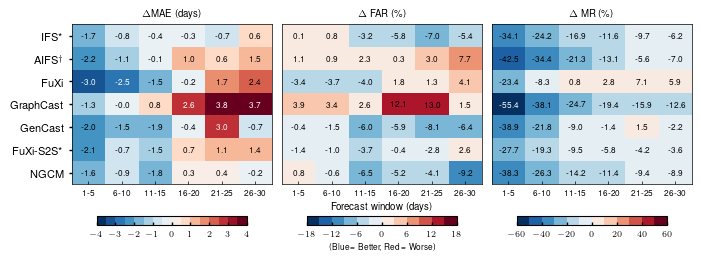

In [28]:
# Run Fig. 3
fig = create_climatology_difference_heatmap(
    weekly_file="./5day_forecastwindow_cmz_2019_2024.mat",
    out_png="fig3.png",
    out_pdf="fig3.pdf",
)
plt.show()
